<a href="https://colab.research.google.com/github/Steven032/ECE1512-2023F-ProjectRepo-Xiaohu.Yang-Yixin.Feng/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
tf.random.set_seed(1234)


tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
mnist_train

<_BatchDataset element_spec=(TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 10), dtype=tf.float32, name=None))>

# Model creation

In [ ]:
from keras.api._v2.keras import activations
from tensorflow.python.ops.gen_nn_ops import conv2d
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(tf.keras.layers.Conv2D(filters= 32,kernel_size = (3,3),strides = (1,1),activation="relu"))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides =(1,1)))
cnn_model.add(tf.keras.layers.Conv2D(64,(3,3),(1,1),activation = 'relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides =(2,2)))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(rate = 0.5))
cnn_model.add(tf.keras.layers.Dense(128,activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(rate = 0.5))
cnn_model.add(tf.keras.layers.Dense(10))


# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model.add(tf.keras.layers.Dense(10))






# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  logits = cnn_model(images, training = True)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits)


  return cross_entropy_loss_value

# Student loss function

In [ ]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  #distillation loss
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits)).numpy()
  #total loss
  loss = ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value
  return loss

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  accuracies = []
  # your code start from here for step 4
  optimizer = tf.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value,model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    accuracies.append((num_correct / num_total * 100).numpy())
  return accuracies


# Training models

In [ ]:
# your code start from here for step 5

train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: 

Class_accuracy: 98.23%
Epoch 2: Class_accuracy: 98.73%
Epoch 3: Class_accuracy: 98.80%
Epoch 4: Class_accuracy: 98.87%
Epoch 5: Class_accuracy: 99.04%
Epoch 6: Class_accuracy: 98.92%
Epoch 7: Class_accuracy: 99.18%
Epoch 8: Class_accuracy: 99.18%
Epoch 9: Class_accuracy: 99.06%
Epoch 10: Class_accuracy: 99.30%
Epoch 11: Class_accuracy: 99.31%
Epoch 12: Class_accuracy: 99.30%


[98.229996,
 98.729996,
 98.799995,
 98.869995,
 99.04,
 98.92,
 99.18,
 99.18,
 99.06,
 99.299995,
 99.31,
 99.299995]

In [ ]:
train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 97.03%
Epoch 2: Class_accuracy: 97.96%
Epoch 3: Class_accuracy: 98.29%
Epoch 4: Class_accuracy: 98.47%
Epoch 5: Class_accuracy: 98.53%
Epoch 6: Class_accuracy: 98.71%
Epoch 7: Class_accuracy: 98.69%
Epoch 8: Class_accuracy: 98.72%
Epoch 9: Class_accuracy: 98.77%
Epoch 10: Class_accuracy: 98.78%
Epoch 11: Class_accuracy: 98.79%
Epoch 12: Class_accuracy: 98.74%


[97.03,
 97.96,
 98.29,
 98.47,
 98.53,
 98.71,
 98.689995,
 98.72,
 98.77,
 98.78,
 98.79,
 98.74]

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
T = [1,2,4,16,32,64]
acc_lst = []
for temperature in T:
  #global DISTILLATION_TEMPERATURE
  DISTILLATION_TEMPERATURE = temperature
  acc = train_and_evaluate(fc_model, compute_student_loss)
  acc_lst.append(acc)
  #print(acc_lst)



Epoch 1: Class_accuracy: 98.46%
Epoch 2: Class_accuracy: 98.51%
Epoch 3: Class_accuracy: 98.48%
Epoch 4: Class_accuracy: 98.65%
Epoch 5: Class_accuracy: 98.60%
Epoch 6: Class_accuracy: 98.58%
Epoch 7: Class_accuracy: 98.60%
Epoch 8: Class_accuracy: 98.62%
Epoch 9: Class_accuracy: 98.47%
Epoch 10: Class_accuracy: 98.70%
Epoch 11: Class_accuracy: 98.76%
Epoch 12: Class_accuracy: 98.72%
Epoch 1: Class_accuracy: 98.79%
Epoch 2: Class_accuracy: 98.82%
Epoch 3: Class_accuracy: 98.84%
Epoch 4: Class_accuracy: 98.78%
Epoch 5: Class_accuracy: 98.82%
Epoch 6: Class_accuracy: 98.69%
Epoch 7: Class_accuracy: 98.85%
Epoch 8: Class_accuracy: 98.90%
Epoch 9: Class_accuracy: 98.83%
Epoch 10: Class_accuracy: 98.91%
Epoch 11: Class_accuracy: 98.81%
Epoch 12: Class_accuracy: 98.85%
Epoch 1: Class_accuracy: 98.84%
Epoch 2: Class_accuracy: 98.88%
Epoch 3: Class_accuracy: 98.92%
Epoch 4: Class_accuracy: 98.90%
Epoch 5: Class_accuracy: 98.90%
Epoch 6: Class_accuracy: 98.88%
Epoch 7: Class_accuracy: 98.94%
Ep

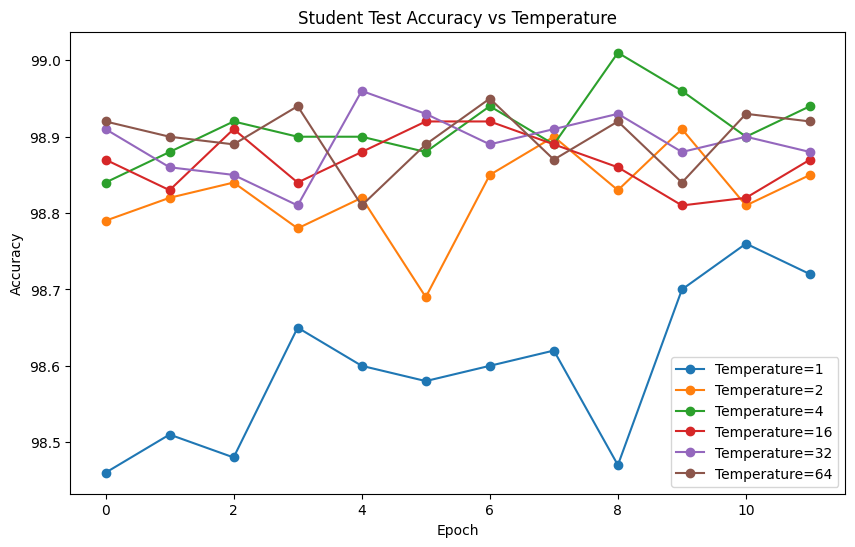

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title('Student Test Accuracy vs Temperature')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

for i, t in enumerate(T):
    plt.plot(acc_lst[i], label=f'Temperature={t}', linestyle='-', marker='o')

plt.legend()
plt.show()


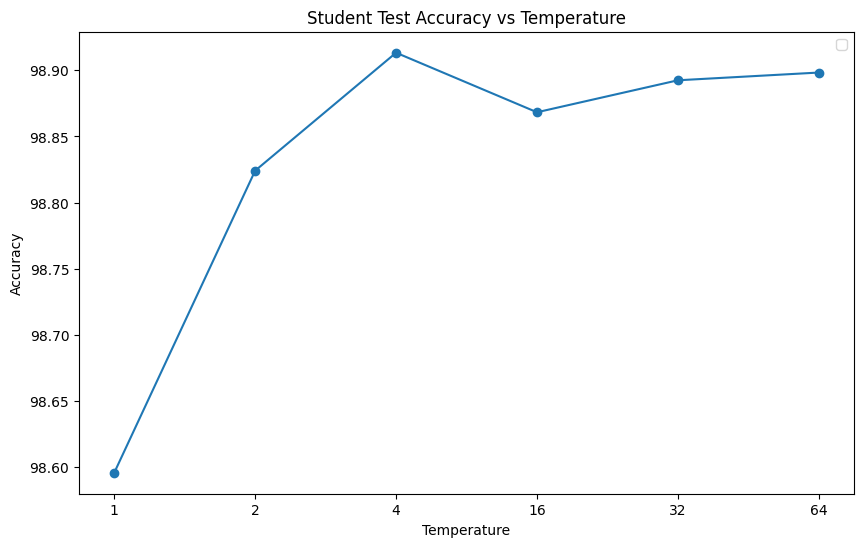

In [ ]:
import numpy as np
acc_lst_np = np.array(acc_lst)
avg_acc = np.mean(acc_lst_np,axis = 1)
T = [1,2,4,16,32,64]
plt.figure(figsize=(10,6))
plt.title('Student Test Accuracy vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
x = list(range(len(T)))

plt.plot(avg_acc, linestyle='-', marker='o')
plt.xticks(x, T)

plt.legend()
plt.show()


In [ ]:
# your code start from here for step 6
T = [0.3,0.4,0.5,0.6,0.7]
acc_lst = []
for temperature in T:
  #global DISTILLATION_TEMPERATURE
  DISTILLATION_TEMPERATURE = 64
  ALPHA = temperature
  acc = train_and_evaluate(fc_model, compute_student_loss)
  acc_lst.append(acc)
  #print(acc_lst)

Epoch 1: Class_accuracy: 98.96%
Epoch 2: Class_accuracy: 98.93%
Epoch 3: Class_accuracy: 98.95%
Epoch 4: Class_accuracy: 98.92%
Epoch 5: Class_accuracy: 98.93%
Epoch 6: Class_accuracy: 98.89%
Epoch 7: Class_accuracy: 98.93%
Epoch 8: Class_accuracy: 98.91%
Epoch 9: Class_accuracy: 98.92%
Epoch 10: Class_accuracy: 98.88%
Epoch 11: Class_accuracy: 98.90%
Epoch 12: Class_accuracy: 98.93%
Epoch 1: Class_accuracy: 98.93%
Epoch 2: Class_accuracy: 98.92%
Epoch 3: Class_accuracy: 98.92%
Epoch 4: Class_accuracy: 98.89%
Epoch 5: Class_accuracy: 98.90%
Epoch 6: Class_accuracy: 98.89%
Epoch 7: Class_accuracy: 98.86%
Epoch 8: Class_accuracy: 98.94%
Epoch 9: Class_accuracy: 98.93%
Epoch 10: Class_accuracy: 98.90%
Epoch 11: Class_accuracy: 98.90%
Epoch 12: Class_accuracy: 98.95%
Epoch 1: Class_accuracy: 98.96%
Epoch 2: Class_accuracy: 98.91%
Epoch 3: Class_accuracy: 98.94%
Epoch 4: Class_accuracy: 98.93%
Epoch 5: Class_accuracy: 98.93%
Epoch 6: Class_accuracy: 98.93%
Epoch 7: Class_accuracy: 98.98%
Ep

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(10))



#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits)

  return cross_entropy_loss

DISTILLATION_TEMPERATURE = 4
train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

# Comparing the teacher and student model (number of of parameters and FLOPs)

In [ ]:
# your code start from here for step 8
cnn_model.summary()
fc_model.summary()

In [ ]:
import tensorflow as tf

def get_flops(model):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.clone_model(model)
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

In [ ]:
print(f"Total FLOPs: {get_flops(cnn_model)}")
print(f"Total FLOPs: {get_flops(fc_model)}")


Total FLOPs: 6519243
Total FLOPs: 8993550


https://stackoverflow.com/questions/45085938/tensorflow-is-there-a-way-to-measure-flops-for-a-model

# Paper 9-Implementing the state-of-the-art KD algorithm - Yixin Feng

In [ ]:
#@test {"output": "ignore"}
from tensorflow.keras.losses import KLDivergence

ALPHA = 0.6 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter


def distillation_loss_new(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature, axis=-1)
  soft_student_logits = tf.nn.softmax(student_logits / temperature, axis=-1)
  return tf.reduce_mean(KLDivergence()(soft_targets, soft_student_logits)) * (temperature ** 2)
  # soft_targets = tf.nn.softmax(teacher_logits/temperature)

  # return tf.reduce_mean(
  #     tf.nn.softmax_cross_entropy_with_logits(
  #         soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss_new(images, labels,teacher_model,student_model):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student_model(images, training=True)
  #print('student_subclass_logits:',student_subclass_logits.shape)
  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = teacher_model(images, training=False)
  #print('teacher_subclass_logits:',teacher_subclass_logits.shape)
  distillation_loss_value = distillation_loss_new(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits)).numpy()
  #print()
  loss = ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value
  return loss

In [ ]:
from keras.api._v2.keras import activations
from tensorflow.python.ops.gen_nn_ops import conv2d
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(tf.keras.layers.Conv2D(filters= 32,kernel_size = (3,3),strides = (1,1),activation="relu"))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides =(1,1)))
cnn_model.add(tf.keras.layers.Conv2D(64,(3,3),(1,1),activation = 'relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides =(2,2)))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(rate = 0.5))
cnn_model.add(tf.keras.layers.Dense(128,activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(rate = 0.5))
cnn_model.add(tf.keras.layers.Dense(10))

# Build Teacher Assistant (TA) model
ta_model = tf.keras.Sequential()
ta_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu"))  # Half the filters of teacher
ta_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1,1)))
ta_model.add(tf.keras.layers.Flatten())
ta_model.add(tf.keras.layers.Dense(units=784, activation='relu'))
ta_model.add(tf.keras.layers.Dense(10))
# ta_model.add(tf.keras.layers.Dropout(rate = 0.5))
# ta_model.add(tf.keras.layers.Dense(128,activation='relu'))
# ta_model.add(tf.keras.layers.Dropout(rate = 0.5))
# ta_model.add(tf.keras.layers.Dense(10))


# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model.add(tf.keras.layers.Dense(10))






In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate_new(model, compute_loss_fn,teacher_model):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  accuracies = []
  # your code start from here for step 4
  optimizer = tf.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels,teacher_model,model)

      grads = tape.gradient(loss_value,model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    accuracies.append((num_correct / num_total * 100).numpy())
  return accuracies


In [ ]:
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.08%
Epoch 2: Class_accuracy: 98.58%
Epoch 3: Class_accuracy: 98.78%
Epoch 4: Class_accuracy: 99.02%
Epoch 5: Class_accuracy: 99.04%
Epoch 6: Class_accuracy: 99.10%
Epoch 7: Class_accuracy: 99.12%
Epoch 8: Class_accuracy: 99.25%
Epoch 9: Class_accuracy: 99.23%
Epoch 10: Class_accuracy: 99.26%
Epoch 11: Class_accuracy: 99.15%
Epoch 12: Class_accuracy: 99.23%


[98.079994,
 98.58,
 98.78,
 99.02,
 99.04,
 99.1,
 99.119995,
 99.25,
 99.229996,
 99.26,
 99.15,
 99.229996]

In [ ]:
train_and_evaluate_new(ta_model, compute_student_loss_new,cnn_model)

Epoch 1: Class_accuracy: 98.27%
Epoch 2: Class_accuracy: 98.74%
Epoch 3: Class_accuracy: 98.93%
Epoch 4: Class_accuracy: 98.92%
Epoch 5: Class_accuracy: 99.05%
Epoch 6: Class_accuracy: 99.05%
Epoch 7: Class_accuracy: 99.13%
Epoch 8: Class_accuracy: 99.06%
Epoch 9: Class_accuracy: 99.06%
Epoch 10: Class_accuracy: 99.08%
Epoch 11: Class_accuracy: 99.09%
Epoch 12: Class_accuracy: 99.08%


[98.27,
 98.74,
 98.93,
 98.92,
 99.049995,
 99.049995,
 99.13,
 99.06,
 99.06,
 99.08,
 99.09,
 99.08]

In [ ]:
train_and_evaluate_new(fc_model, compute_student_loss_new,ta_model)

Epoch 1: Class_accuracy: 96.74%
Epoch 2: Class_accuracy: 97.94%
Epoch 3: Class_accuracy: 98.30%
Epoch 4: Class_accuracy: 98.51%
Epoch 5: Class_accuracy: 98.53%
Epoch 6: Class_accuracy: 98.62%
Epoch 7: Class_accuracy: 98.67%
Epoch 8: Class_accuracy: 98.78%
Epoch 9: Class_accuracy: 98.79%
Epoch 10: Class_accuracy: 98.82%
Epoch 11: Class_accuracy: 98.82%
Epoch 12: Class_accuracy: 98.85%


[96.74,
 97.939995,
 98.299995,
 98.509995,
 98.53,
 98.619995,
 98.67,
 98.78,
 98.79,
 98.82,
 98.82,
 98.85]

# paper 2-Implementing the state-of-the-art KD algorithm - Xiaohu Yang

In [ ]:
NUM_EPOCHS = 20

In [ ]:
from keras.api._v2.keras import activations
from tensorflow.python.ops.gen_nn_ops import conv2d
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(tf.keras.layers.Conv2D(filters= 32,kernel_size = (3,3),strides = (1,1),activation="relu"))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides =(1,1)))
cnn_model.add(tf.keras.layers.Conv2D(64,(3,3),(1,1),activation = 'relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides =(2,2)))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(rate = 0.5))
cnn_model.add(tf.keras.layers.Dense(128,activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(rate = 0.5))
cnn_model.add(tf.keras.layers.Dense(10))


# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model.add(tf.keras.layers.Dense(10))


In [ ]:
# Build fully connected student.
fc_model_orig = tf.keras.Sequential()
fc_model_orig.add(tf.keras.layers.Flatten())
fc_model_orig.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model_orig.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model_orig.add(tf.keras.layers.Dense(10))

In [ ]:
from tensorflow.keras.losses import KLDivergence

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  logits = cnn_model(images, training = True)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits)


  return cross_entropy_loss_value

In [ ]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 64. #temperature hyperparameter

def distillation_loss_KD(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature, axis=-1)
  soft_student_logits = tf.nn.softmax(student_logits / temperature, axis=-1)
  return tf.reduce_mean(KLDivergence()(soft_targets, soft_student_logits)) * (temperature ** 2)

def compute_student_loss_ES(images, labels,epochs):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)
  # your code start from here for step 3
  #distillation loss
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss_KD(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)
  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits)).numpy()
  if epochs <=10:
  #total loss
    loss = ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value
  else:
    cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits))
    loss = cross_entropy_loss_value
  return loss

In [ ]:
def compute_student_loss_original(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model_orig(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  #distillation loss
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss_KD(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits)).numpy()
  #total loss
  loss = ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value
  return loss

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate_ES(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  accuracies = []
  optimizer = tf.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        if compute_loss_fn == compute_teacher_loss:
          loss_value = compute_loss_fn(images,labels)
        elif compute_loss_fn == compute_student_loss_original:
          loss_value = compute_loss_fn(images,labels)
        else:
          loss_value = compute_loss_fn(images,labels,epoch)

      grads = tape.gradient(loss_value,model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    accuracies.append((num_correct / num_total * 100).numpy())
  return accuracies


In [ ]:
train_and_evaluate_ES(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.21%
Epoch 2: Class_accuracy: 98.51%
Epoch 3: Class_accuracy: 98.88%
Epoch 4: Class_accuracy: 98.90%
Epoch 5: Class_accuracy: 99.12%
Epoch 6: Class_accuracy: 99.06%
Epoch 7: Class_accuracy: 99.17%
Epoch 8: Class_accuracy: 99.27%
Epoch 9: Class_accuracy: 99.29%
Epoch 10: Class_accuracy: 99.27%
Epoch 11: Class_accuracy: 99.21%
Epoch 12: Class_accuracy: 99.30%
Epoch 13: Class_accuracy: 99.31%
Epoch 14: Class_accuracy: 99.23%
Epoch 15: Class_accuracy: 99.27%
Epoch 16: Class_accuracy: 99.30%
Epoch 17: Class_accuracy: 99.20%
Epoch 18: Class_accuracy: 99.19%
Epoch 19: Class_accuracy: 99.36%
Epoch 20: Class_accuracy: 99.29%


[98.21,
 98.509995,
 98.88,
 98.9,
 99.119995,
 99.06,
 99.17,
 99.27,
 99.29,
 99.27,
 99.21,
 99.299995,
 99.31,
 99.229996,
 99.27,
 99.299995,
 99.2,
 99.19,
 99.36,
 99.29]

In [ ]:
train_and_evaluate_ES(fc_model, compute_student_loss_ES)

Epoch 1: Class_accuracy: 96.53%
Epoch 2: Class_accuracy: 97.79%
Epoch 3: Class_accuracy: 98.15%
Epoch 4: Class_accuracy: 98.41%
Epoch 5: Class_accuracy: 98.56%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.63%
Epoch 8: Class_accuracy: 98.62%
Epoch 9: Class_accuracy: 98.67%
Epoch 10: Class_accuracy: 98.71%
Epoch 11: Class_accuracy: 98.63%
Epoch 12: Class_accuracy: 98.92%
Epoch 13: Class_accuracy: 98.81%
Epoch 14: Class_accuracy: 98.85%
Epoch 15: Class_accuracy: 98.81%
Epoch 16: Class_accuracy: 98.89%
Epoch 17: Class_accuracy: 98.86%
Epoch 18: Class_accuracy: 98.90%
Epoch 19: Class_accuracy: 98.91%
Epoch 20: Class_accuracy: 98.97%


[96.53,
 97.79,
 98.15,
 98.409996,
 98.56,
 98.54,
 98.63,
 98.619995,
 98.67,
 98.71,
 98.63,
 98.92,
 98.81,
 98.85,
 98.81,
 98.89,
 98.86,
 98.9,
 98.909996,
 98.97]

In [ ]:
train_and_evaluate_ES(fc_model_orig, compute_student_loss_original)

Epoch 1: Class_accuracy: 96.54%
Epoch 2: Class_accuracy: 97.75%
Epoch 3: Class_accuracy: 98.18%
Epoch 4: Class_accuracy: 98.50%
Epoch 5: Class_accuracy: 98.50%
Epoch 6: Class_accuracy: 98.56%
Epoch 7: Class_accuracy: 98.62%
Epoch 8: Class_accuracy: 98.79%
Epoch 9: Class_accuracy: 98.85%
Epoch 10: Class_accuracy: 98.85%
Epoch 11: Class_accuracy: 98.80%
Epoch 12: Class_accuracy: 98.78%
Epoch 13: Class_accuracy: 98.90%
Epoch 14: Class_accuracy: 98.89%
Epoch 15: Class_accuracy: 98.87%
Epoch 16: Class_accuracy: 98.82%
Epoch 17: Class_accuracy: 98.86%
Epoch 18: Class_accuracy: 98.86%
Epoch 19: Class_accuracy: 98.85%
Epoch 20: Class_accuracy: 98.92%


[96.54,
 97.75,
 98.18,
 98.5,
 98.5,
 98.56,
 98.619995,
 98.79,
 98.85,
 98.85,
 98.799995,
 98.78,
 98.9,
 98.89,
 98.869995,
 98.82,
 98.86,
 98.86,
 98.85,
 98.92]

# XAI method to explain models

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=70ebf529a14a0f4c2726f08627ed91c57ef9686699c5479f5ccc6e78aac05436
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


(1, 28, 28, 1)
(28, 28)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


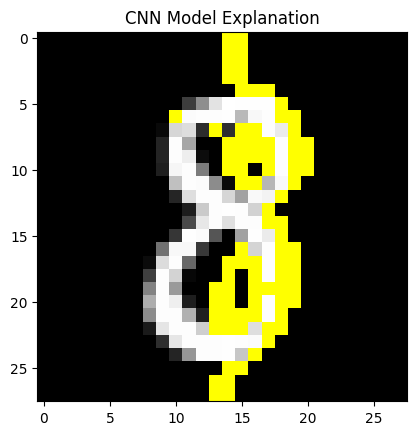

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


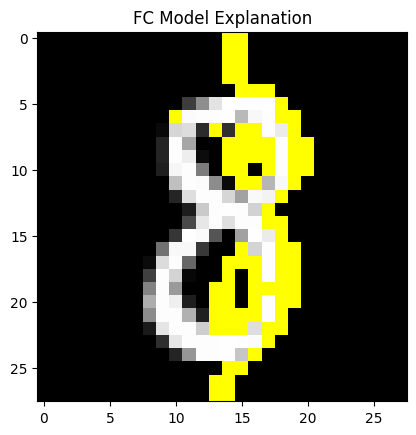

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


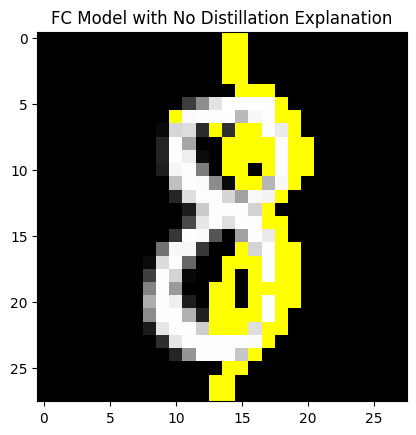

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Define prediction functions for both models
def cnn_predict(images):

    images = tf.expand_dims(images, axis=-1)
    return cnn_model.predict(images[:, :, :, 0])

def fc_predict(images):


    return fc_model.predict(images[:, :, :, 0])

def fc_nondistill_predict(images):

    return fc_model_no_distillation.predict(images[:, :, :, 0])


# Create an explainer object
explainer = lime_image.LimeImageExplainer()

for images, labels in mnist_train.take(1):
    sample_images = images
    sample_labels = labels
sample_image = sample_images[2:3]
print(sample_image.shape)
print(sample_image[0, :, :, 0].shape)
# Explain using the cnn_model
explanation_cnn = explainer.explain_instance(sample_image[0, :, :, 0],
                                             cnn_predict,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)

# Visualize the explanation for the top class
temp, mask = explanation_cnn.get_image_and_mask(explanation_cnn.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title('CNN Model Explanation')
plt.show()

# Explain using the fc_model
explanation_fc = explainer.explain_instance(sample_image[0, :, :, 0],
                                           fc_predict,
                                           top_labels=5,
                                           hide_color=0,
                                           num_samples=1000)

# Visualize the explanation for the top class
temp, mask = explanation_fc.get_image_and_mask(explanation_fc.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title('FC Model Explanation')
plt.show()


# Explain using the fc_model_nondistill
explanation_fc_non_distill = explainer.explain_instance(sample_image[0, :, :, 0],
                                           fc_nondistill_predict,
                                           top_labels=5,
                                           hide_color=0,
                                           num_samples=1000)

# Visualize the explanation for the top class
temp, mask = explanation_fc.get_image_and_mask(explanation_fc_non_distill.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title('FC Model with No Distillation Explanation')
plt.show()
